In [ ]:
!gdown https://drive.google.com/uc?id=1ffb56QRX_BBdSjkWLpEVwd354rnUzxpM
!gdown https://drive.google.com/uc?id=1X8KgJa7h3ovV-jGca0tW_RA0Q7jR1yD5
!gdown https://drive.google.com/uc?id=1DLN2Jmz5Ky9udPLvlh1o8Q6kFyAQ_8AS

In [ ]:
!unzip -qq '/content/train_test_dataset_Fault Impact Analysis.zip'
!unzip -qq /content/energy_consumption.zip
!unzip -qq validation_clean.zip

In [ ]:
!pip install -qq pandarallel --quiet
!pip install -qq optuna --quiet
!pip install -qq category_encoders
!pip install -qq catboost

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import optuna
import warnings
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from xgboost import DMatrix, XGBClassifier, plot_importance
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error,r2_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn import preprocessing
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor
import matplotlib.pyplot as plt
import lightgbm as lgbm
import lightgbm as lgb
from multiprocessing import Pool
from functools import partial
import gc
import xgboost as xgb
import seaborn as sns
warnings.filterwarnings('ignore')

from pandarallel import pandarallel
pandarallel.initialize(use_memory_fs=False, nb_workers=os.cpu_count(), progress_bar=True)
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

# Feature Selection
from sklearn.feature_selection import chi2, f_classif, f_regression
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile, VarianceThreshold

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
sub_df = pd.read_csv('SampleSubmission.csv')
display(sub_df.shape, sub_df.head(),
)

(26139, 2)

,Time,Energy
0,2023-01-01 06:00:00,0
1,2023-01-01 11:00:00,0
2,2023-01-01 12:00:00,0
3,2023-01-01 13:00:00,0
4,2023-01-01 23:00:00,0


In [ ]:
!ls

 BSinfo.csv
 CLdata.csv
 ECdata.csv
 energy_consumption.zip
 manifest-db3982178dc615022c0a516565ebbef920230726-4528-19qthjg.json
 power_consumption_prediction.csv
 sample_data
'SampleSubmission (41).csv'
 SampleSubmission.csv
'train_test_dataset_Fault Impact Analysis'
'train_test_dataset_Fault Impact Analysis.zip'
 validation_clean
 validation_clean.zip
 validation_features_all.csv


In [ ]:
glob.glob('train_test_dataset_Fault Impact Analysis//*.csv')

['train_test_dataset_Fault Impact Analysis/B0373-22_9.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0630-22_22.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0434-13_9.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0422-25_9.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0254-35_10.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0518-35_10.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0163-112_1.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0571-13_2.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0581-12_1.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0178-32_26.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0432-35_1.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0308-53_19.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0192-23_26.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0373-23_10.csv.csv',
 'train_test_dataset_Fault Impact Analysis/B0320-213_1.csv.csv',
 'train_test_dataset_Fault Impa

In [ ]:
variable_columns = ['access_success_rate', 'resource_utilition_rate', 'TA', 'bler', 'cqi', 'mcs', 'data_rate']
static_columns = ['fault_duration', 'relation']

In [ ]:
time_categorical = ['hour', *[f"hour{t}" for t in [2,3,4,6]], 'weekday', 'morning', 'business_hour', 'business_day']
time_numerical = [f"{sub}_{fin}" for sub in ['hour', *[f"hour{t}" for t in [2,3,4,6]], 'weekday'] for fin in ['sin', 'cos', 'float']]
time_features = time_categorical + time_numerical
len(time_features)

27

In [ ]:
def load_train(filepath):
    ID = os.path.basename(filepath).split('.')[0]
    df = pd.read_csv(filepath)
    fault_hours = (df.fault_duration!=0).sum()
    target = 1 * (df['data_rate'].iloc[-fault_hours] <  df['data_rate'].iloc[1-fault_hours])
    df['ID'] = ID
    columns_order = ['ID'] + [column for column in df.columns if column!='ID']
    df = df[columns_order]
    if fault_hours == len(df):
        df['target'] = np.nan
        return df
    df['next_rate'] = df['data_rate'].shift(-1)
    df.loc[df.fault_duration!=0, variable_columns] = np.nan
    if fault_hours != 1:
        df = df.iloc[:-(fault_hours-1)]

    targets = [0] * len(df)
    targets[-1] = target
    df['target'] = targets

    df[['fault_duration', 'relation', 'target']] = df[['fault_duration', 'relation', 'target']].shift(-1)
    df = df.iloc[:-1]
    return df

In [ ]:
def load_test(filepath):
    ID = os.path.basename(filepath).split('.')[0]
    df = pd.read_csv(filepath)
    df['ID'] = ID
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    columns_order = ['ID'] + [column for column in df.columns if column!='ID']
    df = df[columns_order]
    df['next_rate'] = df['data_rate'].shift(-1)
    df[['fault_duration', 'relation']] = df[['fault_duration', 'relation']].shift(-1)
    df = df.iloc[:-1]
    return df

In [ ]:
def add_time_features(df0, timeColumn='endTime'):
    df = df0.copy()
    df[timeColumn] = pd.to_datetime(df[timeColumn])
    df['weekday'] = df[timeColumn].dt.weekday
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday']/7.0)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday']/7.0)
    df['weekday_float']  = df['weekday']/6.0 - 0.5

    df['hour'] = df[timeColumn].dt.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24.0)
    df['hour_float']  = df['hour']/23.0 - 0.5

    for t in [2, 3, 4, 6]:
        df[f'hour{t}'] = df['hour'] // t
        df[f'hour{t}_sin'] = np.sin(2 * np.pi * df[f'hour{t}']/(24.0/t))
        df[f'hour{t}_cos'] = np.cos(2 * np.pi * df[f'hour{t}']/(24.0/t))
        df[f'hour{t}_float'] = df[f'hour{t}']/(24.0/t - 1) - 0.5

    df['morning'] = 1 * (df['hour'] < 12)
    df['business_hour'] = 1 *((df['hour']>8) & (df['hour'] < 17))
    df['business_day'] = 1 *((df['weekday']>0) & (df['hour'] < 6))
    return df

In [ ]:
%%time
train_df = pd.concat(pd.DataFrame(np.sort(glob.glob('train_test_dataset_Fault Impact Analysis/*.csv')), columns=['filepath'])['filepath'].map(load_train).tolist(), axis=0, ignore_index=True)
# drop those not needed
train_df = train_df[~train_df['target'].isna()].reset_index(drop=True)

# drop the any row with NaN
train_df = train_df[~train_df.isnull().any(axis=1)].reset_index(drop=True)

CPU times: user 1min 17s, sys: 1.77 s, total: 1min 19s
Wall time: 1min 42s


In [ ]:
train_df.head(2)

,ID,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,next_rate,target
0,B0001-12_1,B0001-12,2023-02-09 01:00:00,99.519744,29.417,0.636289,10.126880,8.640631,12.523579,32.209893,0.0,0.0,37.591142,0.0
1,B0001-12_1,B0001-12,2023-02-09 02:00:00,99.216125,15.894,0.711312,9.145678,8.749684,10.642076,37.591142,0.0,0.0,24.761631,0.0


In [ ]:
train_df.isnull().any(axis=0)

ID                         False
NE ID                      False
endTime                    False
access_success_rate        False
resource_utilition_rate    False
TA                         False
bler                       False
cqi                        False
mcs                        False
data_rate                  False
fault_duration             False
relation                   False
next_rate                  False
target                     False
dtype: bool

In [ ]:
train_df[train_df.ID == 'B0002-22_1']

,ID,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,next_rate,target
1656,B0002-22_1,B0002-22,2023-02-09 01:00:00,99.809087,27.052,2.584681,10.507017,6.386473,7.842858,13.773574,0.0,0.0,14.875224,0.0
1657,B0002-22_1,B0002-22,2023-02-09 02:00:00,99.968603,26.802,2.556288,10.599194,6.343484,7.581347,14.875224,0.0,0.0,16.111950,0.0
1658,B0002-22_1,B0002-22,2023-02-09 03:00:00,99.891814,18.869,2.557836,9.538420,6.702705,7.402088,16.111950,0.0,0.0,27.259170,0.0
1659,B0002-22_1,B0002-22,2023-02-09 04:00:00,100.000000,12.833,2.637591,7.555192,6.717687,7.111135,27.259170,0.0,0.0,23.589648,0.0
1660,B0002-22_1,B0002-22,2023-02-09 05:00:00,99.920761,8.437,2.553290,5.983325,6.659262,4.910537,23.589648,0.0,0.0,9.110796,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2131,B0002-22_1,B0002-22,2023-02-28 21:00:00,99.817215,51.463,2.423796,11.603783,7.010091,7.776594,6.722747,0.0,0.0,7.088263,0.0
2132,B0002-22_1,B0002-22,2023-02-28 22:00:00,99.824800,49.497,2.474828,12.198831,6.740315,7.491963,7.088263,0.0,0.0,5.330612,0.0
2133,B0002-22_1,B0002-22,2023-02-28 23:00:00,99.587979,66.176,2.545692,12.251938,6.450755,7.624957,5.330612,0.0,0.0,7.580673,0.0
2134,B0002-22_1,B0002-22,2023-03-01 00:00:00,99.845105,46.539,2.551511,11.478213,6.214193,6.621469,7.580673,0.0,0.0,9.944211,0.0


In [ ]:
train_df.corr(numeric_only=True)

,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,next_rate,target
access_success_rate,1.000000,0.177839,0.224438,0.219438,0.477230,0.369982,0.188475,0.003777,0.001722,0.084239,0.007269
resource_utilition_rate,0.177839,1.000000,0.031101,0.337909,-0.155586,0.216191,-0.298506,0.014602,0.022672,-0.275161,0.018275
TA,0.224438,0.031101,1.000000,0.179422,-0.000157,0.008563,-0.098346,0.002399,0.006532,-0.120839,0.002635
bler,0.219438,0.337909,0.179422,1.000000,-0.089833,0.104518,-0.233374,0.004254,0.015822,-0.236868,0.006355
cqi,0.477230,-0.155586,-0.000157,-0.089833,1.000000,0.506751,0.618255,-0.004040,-0.022364,0.522490,-0.003319
mcs,0.369982,0.216191,0.008563,0.104518,0.506751,1.000000,0.315060,0.002488,-0.002057,0.239631,0.002526
data_rate,0.188475,-0.298506,-0.098346,-0.233374,0.618255,0.315060,1.000000,-0.001926,-0.019284,0.719160,-0.005200
fault_duration,0.003777,0.014602,0.002399,0.004254,-0.004040,0.002488,-0.001926,1.000000,0.362622,-0.006190,0.466856
relation,0.001722,0.022672,0.006532,0.015822,-0.022364,-0.002057,-0.019284,0.362622,1.000000,-0.022250,0.294111
next_rate,0.084239,-0.275161,-0.120839,-0.236868,0.522490,0.239631,0.719160,-0.006190,-0.022250,1.000000,-0.015019


In [ ]:
train_df.head()

,ID,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,next_rate,target
0,B0001-12_1,B0001-12,2023-02-09 01:00:00,99.519744,29.417,0.636289,10.126880,8.640631,12.523579,32.209893,0.0,0.0,37.591142,0.0
1,B0001-12_1,B0001-12,2023-02-09 02:00:00,99.216125,15.894,0.711312,9.145678,8.749684,10.642076,37.591142,0.0,0.0,24.761631,0.0
2,B0001-12_1,B0001-12,2023-02-09 03:00:00,99.960815,27.401,0.689756,10.123859,9.282525,14.116277,24.761631,0.0,0.0,42.208165,0.0
3,B0001-12_1,B0001-12,2023-02-09 04:00:00,100.000000,19.320,0.675434,9.721365,9.465269,14.872375,42.208165,0.0,0.0,40.002877,0.0
4,B0001-12_1,B0001-12,2023-02-09 05:00:00,99.953315,18.154,0.646022,10.229611,9.270378,15.106532,40.002877,0.0,0.0,31.021982,0.0


In [ ]:
%%time
test_df = pd.concat(pd.DataFrame(np.sort(glob.glob('validation_clean/*.csv')), columns=['filepath'])['filepath'].map(load_test).tolist(), axis=0, ignore_index=True)

CPU times: user 13.6 s, sys: 228 ms, total: 13.8 s
Wall time: 13.9 s


In [ ]:
test_df.head(2)

,ID,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,next_rate
0,B0017-25_24,B0017-25,2023-02-20 06:00:00,99.714558,8.678,3.715410,7.653169,5.964988,5.403557,6.815789,0.0,0.0,6.777114
1,B0017-25_24,B0017-25,2023-02-20 07:00:00,99.927484,24.264,3.145402,10.015796,6.141206,6.544645,6.777114,0.0,0.0,1.175289


In [ ]:
test_df[test_df.ID == 'B0017-25_24']

,ID,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,next_rate
0,B0017-25_24,B0017-25,2023-02-20 06:00:00,99.714558,8.678,3.715410,7.653169,5.964988,5.403557,6.815789,0.0,0.000000,6.777114
1,B0017-25_24,B0017-25,2023-02-20 07:00:00,99.927484,24.264,3.145402,10.015796,6.141206,6.544645,6.777114,0.0,0.000000,1.175289
2,B0017-25_24,B0017-25,2023-02-20 08:00:00,99.357688,84.004,2.923368,14.209819,5.582824,5.667775,1.175289,301.0,0.654162,NaN


In [ ]:
## let's combine both and remove target for now (can be computed later)

df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
df.drop(columns=['target'], inplace=True)

In [ ]:
%%time
df = add_time_features(df)

CPU times: user 793 ms, sys: 205 ms, total: 998 ms
Wall time: 997 ms


In [ ]:
df = df.sort_values(by=['ID', 'endTime'], ignore_index=True)

In [ ]:
df[df.next_rate.isna()].shape

(2895, 40)

In [ ]:
df.isnull().sum(axis=0)

ID                             0
NE ID                          0
endTime                        0
access_success_rate        48937
resource_utilition_rate       98
TA                           790
bler                         487
cqi                          427
mcs                          428
data_rate                    973
fault_duration                 0
relation                       0
next_rate                   2895
weekday                        0
weekday_sin                    0
weekday_cos                    0
weekday_float                  0
hour                           0
hour_sin                       0
hour_cos                       0
hour_float                     0
hour2                          0
hour2_sin                      0
hour2_cos                      0
hour2_float                    0
hour3                          0
hour3_sin                      0
hour3_cos                      0
hour3_float                    0
hour4                          0
hour4_sin 

In [ ]:
df = df[~((df.isnull().any(axis=1) & (df.fault_duration == 0)))].reset_index(drop=True)  # remove all that does not contribute to final test

In [ ]:
df.isnull().sum(axis=0)

ID                            0
NE ID                         0
endTime                       0
access_success_rate         402
resource_utilition_rate       1
TA                            8
bler                          1
cqi                           0
mcs                           0
data_rate                     4
fault_duration                0
relation                      0
next_rate                  1932
weekday                       0
weekday_sin                   0
weekday_cos                   0
weekday_float                 0
hour                          0
hour_sin                      0
hour_cos                      0
hour_float                    0
hour2                         0
hour2_sin                     0
hour2_cos                     0
hour2_float                   0
hour3                         0
hour3_sin                     0
hour3_cos                     0
hour3_float                   0
hour4                         0
hour4_sin                     0
hour4_co

In [ ]:
df

,ID,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,next_rate,weekday,weekday_sin,weekday_cos,weekday_float,hour,hour_sin,hour_cos,hour_float,hour2,hour2_sin,hour2_cos,hour2_float,hour3,hour3_sin,hour3_cos,hour3_float,hour4,hour4_sin,hour4_cos,hour4_float,hour6,hour6_sin,hour6_cos,hour6_float,morning,business_hour,business_day
0,B0001-12_1,B0001-12,2023-02-09 01:00:00,99.519744,29.417000,0.636289,10.126880,8.640631,12.523579,32.209893,0.0,0.0,37.591142,3,0.433884,-0.900969,0.000000,1,0.258819,0.965926,-0.456522,0,0.000000,1.000000,-0.500000,0,0.000000,1.000000e+00,-0.500000,0,0.000000,1.0,-0.5,0,0.0,1.000000e+00,-0.5,1,0,1
1,B0001-12_1,B0001-12,2023-02-09 02:00:00,99.216125,15.894000,0.711312,9.145678,8.749684,10.642076,37.591142,0.0,0.0,24.761631,3,0.433884,-0.900969,0.000000,2,0.500000,0.866025,-0.413043,1,0.500000,0.866025,-0.409091,0,0.000000,1.000000e+00,-0.500000,0,0.000000,1.0,-0.5,0,0.0,1.000000e+00,-0.5,1,0,1
2,B0001-12_1,B0001-12,2023-02-09 03:00:00,99.960815,27.401000,0.689756,10.123859,9.282525,14.116277,24.761631,0.0,0.0,42.208165,3,0.433884,-0.900969,0.000000,3,0.707107,0.707107,-0.369565,1,0.500000,0.866025,-0.409091,1,0.707107,7.071068e-01,-0.357143,0,0.000000,1.0,-0.5,0,0.0,1.000000e+00,-0.5,1,0,1
3,B0001-12_1,B0001-12,2023-02-09 04:00:00,100.000000,19.320000,0.675434,9.721365,9.465269,14.872375,42.208165,0.0,0.0,40.002877,3,0.433884,-0.900969,0.000000,4,0.866025,0.500000,-0.326087,2,0.866025,0.500000,-0.318182,1,0.707107,7.071068e-01,-0.357143,1,0.866025,0.5,-0.3,0,0.0,1.000000e+00,-0.5,1,0,1
4,B0001-12_1,B0001-12,2023-02-09 05:00:00,99.953315,18.154000,0.646022,10.229611,9.270378,15.106532,40.002877,0.0,0.0,31.021982,3,0.433884,-0.900969,0.000000,5,0.965926,0.258819,-0.282609,2,0.866025,0.500000,-0.318182,1,0.707107,7.071068e-01,-0.357143,1,0.866025,0.5,-0.3,0,0.0,1.000000e+00,-0.5,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932310,B0729-22_1,B0729-22,2023-02-27 20:00:00,99.765808,8.464894,3.558491,10.746788,8.111814,5.960899,16.862884,0.0,0.0,14.303917,0,0.000000,1.000000,-0.500000,20,-0.866025,0.500000,0.369565,10,-0.866025,0.500000,0.409091,6,-1.000000,-1.836970e-16,0.357143,5,-0.866025,0.5,0.5,3,-1.0,-1.836970e-16,0.5,0,0,0
932311,B0729-22_1,B0729-22,2023-02-27 21:00:00,100.000000,16.492553,3.574762,11.341579,7.815686,7.988269,14.303917,0.0,0.0,10.155393,0,0.000000,1.000000,-0.500000,21,-0.707107,0.707107,0.413043,10,-0.866025,0.500000,0.409091,7,-0.707107,7.071068e-01,0.500000,5,-0.866025,0.5,0.5,3,-1.0,-1.836970e-16,0.5,0,0,0
932312,B0729-22_1,B0729-22,2023-02-27 22:00:00,98.632011,28.068085,3.599831,11.432605,7.737878,9.927459,10.155393,0.0,0.0,10.971475,0,0.000000,1.000000,-0.500000,22,-0.500000,0.866025,0.456522,11,-0.500000,0.866025,0.500000,7,-0.707107,7.071068e-01,0.500000,5,-0.866025,0.5,0.5,3,-1.0,-1.836970e-16,0.5,0,0,0
932313,B0729-22_1,B0729-22,2023-02-27 23:00:00,99.426934,20.630851,3.288434,11.055750,7.373209,9.584147,10.971475,0.0,0.0,14.851790,0,0.000000,1.000000,-0.500000,23,-0.258819,0.965926,0.500000,11,-0.500000,0.866025,0.500000,7,-0.707107,7.071068e-01,0.500000,5,-0.866025,0.5,0.5,3,-1.0,-1.836970e-16,0.5,0,0,0


In [ ]:
df.corr(numeric_only=True)

,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,next_rate,weekday,weekday_sin,weekday_cos,weekday_float,hour,hour_sin,hour_cos,hour_float,hour2,hour2_sin,hour2_cos,hour2_float,hour3,hour3_sin,hour3_cos,hour3_float,hour4,hour4_sin,hour4_cos,hour4_float,hour6,hour6_sin,hour6_cos,hour6_float,morning,business_hour,business_day
access_success_rate,1.000000,0.184273,0.235456,0.239288,0.486007,0.383907,0.192474,0.005145,0.003363,0.083521,0.009586,-0.007181,-0.004844,0.009586,0.163512,-0.187415,-0.096501,0.163512,0.163245,-0.170693,-0.116968,0.163245,0.161739,-0.154986,-0.133540,0.161739,0.164461,-0.133800,-0.150416,0.164461,0.176551,-0.049061,-0.172806,0.176551,-0.156852,0.117896,-0.165815
resource_utilition_rate,0.184273,1.000000,0.036684,0.342880,-0.148939,0.218263,-0.298506,0.015372,0.024322,-0.275930,0.009410,-0.003698,-0.022745,0.009410,0.295182,-0.359663,-0.047665,0.295182,0.295863,-0.347652,-0.093590,0.295863,0.296332,-0.327247,-0.136509,0.296332,0.300381,-0.300744,-0.183597,0.300381,0.303399,-0.220686,-0.230095,0.303399,-0.318765,0.121756,-0.189044
TA,0.235456,0.036684,1.000000,0.184208,0.003373,0.007958,-0.099080,0.003803,0.007247,-0.123858,0.018022,-0.017964,-0.002664,0.018022,0.047412,-0.056257,-0.026426,0.047412,0.047292,-0.051783,-0.032739,0.047292,0.047050,-0.046809,-0.037861,0.047050,0.047832,-0.040821,-0.042746,0.047832,0.051070,-0.015083,-0.050871,0.051070,-0.046630,0.036310,-0.048496
bler,0.239288,0.342880,0.184208,1.000000,-0.070324,0.115331,-0.228139,0.005808,0.016999,-0.233923,0.012888,-0.009468,-0.010010,0.012888,0.216979,-0.258068,-0.080626,0.216979,0.217342,-0.243005,-0.112252,0.217342,0.216784,-0.224582,-0.139400,0.216784,0.220349,-0.200924,-0.170382,0.220349,0.226387,-0.119915,-0.195107,0.226387,-0.222749,0.125767,-0.173317
cqi,0.486007,-0.148939,0.003373,-0.070324,1.000000,0.512144,0.618936,-0.004465,-0.021569,0.519187,0.000604,-0.003556,0.004373,0.000604,0.006192,-0.002878,-0.032245,0.006192,0.006016,0.002646,-0.030843,0.006016,0.004576,0.003260,-0.028155,0.004576,0.004651,0.006632,-0.024038,0.004651,0.012532,0.031480,-0.027108,0.012532,0.003105,0.022684,-0.035989
mcs,0.383907,0.218263,0.007958,0.115331,0.512144,1.000000,0.318467,0.001473,-0.002233,0.240223,0.012545,-0.011174,-0.000959,0.012545,0.075204,-0.109284,-0.007964,0.075204,0.075294,-0.105905,-0.021349,0.075294,0.074501,-0.102357,-0.032868,0.074501,0.075778,-0.096738,-0.045334,0.075778,0.081470,-0.056424,-0.060027,0.081470,-0.082347,0.042226,-0.051042
data_rate,0.192474,-0.298506,-0.099080,-0.228139,0.618936,0.318467,1.000000,-0.004281,-0.020336,0.719600,0.000915,-0.004266,0.008390,0.000915,-0.107061,0.120892,0.018145,-0.107061,-0.107770,0.116753,0.034990,-0.107770,-0.108504,0.108875,0.049871,-0.108504,-0.109699,0.099355,0.067732,-0.109699,-0.107023,0.080532,0.078951,-0.107023,0.112778,-0.039559,0.065409
fault_duration,0.005145,0.015372,0.003803,0.005808,-0.004465,0.001473,-0.004281,1.000000,0.403955,-0.005001,-0.017329,0.016859,0.011952,-0.017329,-0.006147,-0.008178,-0.011278,-0.006147,-0.006310,-0.006149,-0.011488,-0.006310,-0.004909,-0.005576,-0.012328,-0.004909,-0.004637,-0.002319,-0.012280,-0.004637,-0.003792,0.002971,-0.010339,-0.003792,-0.005208,0.022561,0.004898
relation,0.003363,0.024322,0.007247,0.016999,-0.021569,-0.002233,-0.020336,0.403955,1.000000,-0.020675,-0.018216,0.011328,0.009238,-0.018216,-0.004869,-0.011749,-0.019825,-0.004869,-0.004311,-0.009380,-0.021255,-0.004311,-0.003788,-0.006547,-0.021121,-0.003788,-0.003039,-0.001278,-0.021818,-0.003039,-0.002324,0.002400,-0.016514,-0.002324,-0.009977,0.030156,0.002630
next_rate,0.083521,-0.275930,-0.123858,-0.233923,0.519187,0.240223,0.719600,-0.005001,-0.020675,1.000000,0.001195,-0.004908,0.010427,0.001195,-0.116385,0.113426,0.049891,-0.116385,-0.116169,0.105164,0.062186,-0.116169,-0.115135,0.097178,0.071360,-0.115135,-0.118682,0.085555,0.091410,-0.118682,-0.111574,0.065666,0.096486,-0.111574,0.114652,-0.054708,0.082185


In [ ]:
sub_df.head()

,Time,Energy
0,2023-01-01 06:00:00,0
1,2023-01-01 11:00:00,0
2,2023-01-01 12:00:00,0
3,2023-01-01 13:00:00,0
4,2023-01-01 23:00:00,0


In [ ]:
def add_time_features(df0, timeColumn='endTime'):
    df = df0.copy()
    df['weekday'] = df[timeColumn].dt.weekday
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday']/7.0)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday']/7.0)
    df['weekday_float']  = df['weekday']/6.0 - 0.5

    df['hour'] = df[timeColumn].dt.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24.0)
    df['hour_float']  = df['hour']/23.0 - 0.5

    for t in [2, 3, 4, 6]:
        df[f'hour{t}'] = df['hour'] // t
        df[f'hour{t}_sin'] = np.sin(2 * np.pi * df[f'hour{t}']/(24.0/t))
        df[f'hour{t}_cos'] = np.cos(2 * np.pi * df[f'hour{t}']/(24.0/t))
        df[f'hour{t}_float'] = df[f'hour{t}']/(24.0/t - 1) - 0.5

    df['morning'] = 1 * (df['hour'] < 12)
    df['business_hour'] = 1 *((df['hour']>8) & (df['hour'] < 17))
    df['business_day'] = 1 *((df['weekday']>0) & (df['hour'] < 6))
    return df

In [ ]:
def fault_duration_features(df):
    df['fault_sin'] = np.sin(2 * np.pi * df['fault_duration']/3600.0)
    df['fault_cos'] = np.cos(2 * np.pi * df['fault_duration']/3600.0)

    df['fault_min1'] = df['fault_duration'] // 60
    df[f'fault_min1_sin'] = np.sin(2 * np.pi * (df['fault_min1'])/(60.0))
    df[f'fault_min1_cos'] = np.cos(2 * np.pi * (df['fault_min1'])/(60.0))
    for t in [2, 4, 5, 6, 10, 15, 20, 30]:
        df[f'fault_min{t}'] = df['fault_min1'] // t
        df[f'fault_min{t}_sin'] = np.sin(2 * np.pi * (df['fault_min1'] // t)/(60.0/t))
        df[f'fault_min{t}_cos'] = np.cos(2 * np.pi * (df['fault_min1'] // t)/(60.0/t))
    return df

In [ ]:
fault_categorical = [f"fault_min{k}" for k in [1,2,4,5,6,10,15,20]]
fault_categorical

['fault_min1',
 'fault_min2',
 'fault_min4',
 'fault_min5',
 'fault_min6',
 'fault_min10',
 'fault_min15',
 'fault_min20']

In [ ]:
cat_features = time_categorical + fault_categorical
cat_features

['hour',
 'hour2',
 'hour3',
 'hour4',
 'hour6',
 'weekday',
 'morning',
 'business_hour',
 'business_day',
 'fault_min1',
 'fault_min2',
 'fault_min4',
 'fault_min5',
 'fault_min6',
 'fault_min10',
 'fault_min15',
 'fault_min20']

In [ ]:
df = fault_duration_features(df)
df.head(2)

,ID,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,next_rate,weekday,weekday_sin,weekday_cos,weekday_float,hour,hour_sin,hour_cos,hour_float,hour2,hour2_sin,hour2_cos,hour2_float,hour3,hour3_sin,hour3_cos,hour3_float,hour4,hour4_sin,hour4_cos,hour4_float,hour6,hour6_sin,hour6_cos,hour6_float,morning,business_hour,business_day,fault_sin,fault_cos,fault_min1,fault_min1_sin,fault_min1_cos,fault_min2,fault_min2_sin,fault_min2_cos,fault_min4,fault_min4_sin,fault_min4_cos,fault_min5,fault_min5_sin,fault_min5_cos,fault_min6,fault_min6_sin,fault_min6_cos,fault_min10,fault_min10_sin,fault_min10_cos,fault_min15,fault_min15_sin,fault_min15_cos,fault_min20,fault_min20_sin,fault_min20_cos,fault_min30,fault_min30_sin,fault_min30_cos
0,B0001-12_1,B0001-12,2023-02-09 01:00:00,99.519744,29.417,0.636289,10.126880,8.640631,12.523579,32.209893,0.0,0.0,37.591142,3,0.433884,-0.900969,0.0,1,0.258819,0.965926,-0.456522,0,0.0,1.000000,-0.500000,0,0.0,1.0,-0.5,0,0.0,1.0,-0.5,0,0.0,1.0,-0.5,1,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,B0001-12_1,B0001-12,2023-02-09 02:00:00,99.216125,15.894,0.711312,9.145678,8.749684,10.642076,37.591142,0.0,0.0,24.761631,3,0.433884,-0.900969,0.0,2,0.500000,0.866025,-0.413043,1,0.5,0.866025,-0.409091,0,0.0,1.0,-0.5,0,0.0,1.0,-0.5,0,0.0,1.0,-0.5,1,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
fault_features = df.columns[df.columns.str.startswith('fault')].tolist()
fault_features

['fault_duration',
 'fault_sin',
 'fault_cos',
 'fault_min1',
 'fault_min1_sin',
 'fault_min1_cos',
 'fault_min2',
 'fault_min2_sin',
 'fault_min2_cos',
 'fault_min4',
 'fault_min4_sin',
 'fault_min4_cos',
 'fault_min5',
 'fault_min5_sin',
 'fault_min5_cos',
 'fault_min6',
 'fault_min6_sin',
 'fault_min6_cos',
 'fault_min10',
 'fault_min10_sin',
 'fault_min10_cos',
 'fault_min15',
 'fault_min15_sin',
 'fault_min15_cos',
 'fault_min20',
 'fault_min20_sin',
 'fault_min20_cos',
 'fault_min30',
 'fault_min30_sin',
 'fault_min30_cos']

In [ ]:
df.corr(numeric_only=True).loc['next_rate', df.columns[df.columns.str.startswith('fault')]]

fault_duration    -0.005001
fault_sin          0.005112
fault_cos          0.001698
fault_min1        -0.005071
fault_min1_sin     0.005112
fault_min1_cos     0.001932
fault_min2        -0.005140
fault_min2_sin     0.005012
fault_min2_cos     0.002194
fault_min4        -0.005538
fault_min4_sin     0.003878
fault_min4_cos     0.002650
fault_min5        -0.005651
fault_min5_sin     0.002975
fault_min5_cos     0.002239
fault_min6        -0.005681
fault_min6_sin     0.003342
fault_min6_cos     0.003194
fault_min10       -0.006096
fault_min10_sin    0.002729
fault_min10_cos    0.003367
fault_min15       -0.006104
fault_min15_sin    0.003568
fault_min15_cos    0.003773
fault_min20       -0.005724
fault_min20_sin    0.000879
fault_min20_cos    0.004447
fault_min30       -0.007036
fault_min30_sin   -0.004418
fault_min30_cos    0.006291
Name: next_rate, dtype: float64

In [ ]:
variable_columns

['access_success_rate',
 'resource_utilition_rate',
 'TA',
 'bler',
 'cqi',
 'mcs',
 'data_rate']

In [ ]:
# let's create nex_hour features (target is actually from next hour)
df['next_hour'] = (df['hour'] + 1) % 24

In [ ]:
df['NEclass'] = df['NE ID'].map(lambda x: x.split('-')[0])

In [ ]:
grp_columns = ['access_success_rate', 'resource_utilition_rate', 'TA', 'bler', 'cqi', 'mcs', 'data_rate']

In [ ]:
from scipy.stats import gmean

In [ ]:
all_grp1 = df.groupby(['NEclass', 'weekday', 'next_hour'])[grp_columns].mean().add_prefix('grp1__')

all_grp1 = all_grp1.reset_index()
all_grp1

,NEclass,weekday,next_hour,grp1__access_success_rate,grp1__resource_utilition_rate,grp1__TA,grp1__bler,grp1__cqi,grp1__mcs,grp1__data_rate
0,B0001,0,0,99.984474,37.160500,0.909654,11.008882,8.478523,12.055003,16.424815
1,B0001,0,1,99.982485,40.979500,0.833334,11.993211,8.354335,10.906432,17.369620
2,B0001,0,2,99.987171,30.889750,0.802434,11.240040,8.675679,11.828956,21.359818
3,B0001,0,3,99.956568,29.918833,0.784580,11.795765,8.970210,12.387330,24.638689
4,B0001,0,4,99.993214,13.796583,0.795064,9.405169,9.464901,11.777928,31.513580
...,...,...,...,...,...,...,...,...,...,...
106240,B0729,6,19,99.852493,40.707014,3.417678,10.663386,8.069811,9.985902,17.768853
106241,B0729,6,20,99.846462,38.387204,3.347708,10.653687,8.296894,10.020646,16.473423
106242,B0729,6,21,99.759441,38.757457,3.361513,10.549298,8.391794,10.306468,17.441082
106243,B0729,6,22,99.818065,43.130837,3.368946,10.750840,8.215051,10.356833,12.888228


In [ ]:
all_grp2 = df.groupby(['NE ID', 'weekday', 'next_hour'])[grp_columns].mean().add_prefix('grp2__')

all_grp2 = all_grp2.reset_index()
all_grp2

,NE ID,weekday,next_hour,grp2__access_success_rate,grp2__resource_utilition_rate,grp2__TA,grp2__bler,grp2__cqi,grp2__mcs,grp2__data_rate
0,B0001-12,0,0,100.000000,37.541000,0.763296,11.408897,8.025336,10.992430,17.760998
1,B0001-12,0,1,99.965706,43.919000,0.730295,11.382445,7.893696,11.275879,18.221507
2,B0001-12,0,2,99.964158,32.992500,0.709067,10.568456,8.159700,12.972792,34.022034
3,B0001-12,0,3,99.739405,42.420500,0.716134,10.454891,8.386265,13.916952,45.453565
4,B0001-12,0,4,100.000000,24.311000,0.685559,9.342099,9.074277,12.913989,37.438667
...,...,...,...,...,...,...,...,...,...,...
482864,B0729-22,6,19,99.776980,16.611702,3.821424,10.554189,7.127098,8.138572,16.832419
482865,B0729-22,6,20,99.838473,11.330851,3.669461,10.720334,7.387666,7.830504,15.134626
482866,B0729-22,6,21,99.381676,9.450355,3.627051,9.907533,7.767925,6.660403,10.114221
482867,B0729-22,6,22,99.576453,12.430851,3.577434,10.445358,7.601745,8.729963,11.764961


In [ ]:
df = df.merge(all_grp1, on=['NEclass', 'weekday', 'next_hour'], how='left')
df = df.merge(all_grp2, on=['NE ID', 'weekday', 'next_hour'], how='left')

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler, MaxAbsScaler

In [ ]:
df = df[df.fault_duration != 0].reset_index(drop=True) # remove non-fault cases
df['target'] = 1 * (df['next_rate'] < df['data_rate'])  #create the target now

In [ ]:
train = df[~df['next_rate'].isna()].reset_index(drop=True)
test = df[df['next_rate'].isna()].reset_index(drop=True)

train.shape, test.shape

((7098, 86), (1932, 86))

In [ ]:
test.head(2)

,ID,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,next_rate,weekday,weekday_sin,weekday_cos,weekday_float,hour,hour_sin,hour_cos,hour_float,hour2,hour2_sin,hour2_cos,hour2_float,hour3,hour3_sin,hour3_cos,hour3_float,hour4,hour4_sin,hour4_cos,hour4_float,hour6,hour6_sin,hour6_cos,hour6_float,morning,business_hour,business_day,fault_sin,fault_cos,fault_min1,fault_min1_sin,fault_min1_cos,fault_min2,fault_min2_sin,fault_min2_cos,fault_min4,fault_min4_sin,fault_min4_cos,fault_min5,fault_min5_sin,fault_min5_cos,fault_min6,fault_min6_sin,fault_min6_cos,fault_min10,fault_min10_sin,fault_min10_cos,fault_min15,fault_min15_sin,fault_min15_cos,fault_min20,fault_min20_sin,fault_min20_cos,fault_min30,fault_min30_sin,fault_min30_cos,next_hour,NEclass,grp1__access_success_rate,grp1__resource_utilition_rate,grp1__TA,grp1__bler,grp1__cqi,grp1__mcs,grp1__data_rate,grp2__access_success_rate,grp2__resource_utilition_rate,grp2__TA,grp2__bler,grp2__cqi,grp2__mcs,grp2__data_rate,target
0,B0017-25_24,B0017-25,2023-02-20 08:00:00,99.357688,84.004,2.923368,14.209819,5.582824,5.667775,1.175289,301.0,0.654162,NaN,0,0.0,1.0,-0.5,8,0.866025,-0.5,-0.152174,4,0.866025,-0.5,-0.136364,2,1.0,6.123234e-17,-0.214286,2,0.866025,-0.5,-0.1,1,1.0,6.123234e-17,-0.166667,1,0,0,0.501511,0.865151,5.0,0.500000,0.866025,2.0,0.406737,0.913545,1.0,0.406737,0.913545,1.0,0.5,0.866025,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,9,B0017,99.116726,70.708500,2.733639,13.597505,6.247730,6.229603,1.960737,99.467393,86.205,2.974145,14.360231,5.672343,5.745131,1.075847,0
1,B0017-25_25,B0017-25,2023-02-20 20:00:00,99.642289,92.242,2.877206,15.083843,5.628569,5.051611,0.966620,145.0,0.654162,NaN,0,0.0,1.0,-0.5,20,-0.866025,0.5,0.369565,10,-0.866025,0.5,0.409091,6,-1.0,-1.836970e-16,0.357143,5,-0.866025,0.5,0.5,3,-1.0,-1.836970e-16,0.500000,0,0,0,0.250380,0.968148,2.0,0.207912,0.978148,1.0,0.207912,0.978148,0.0,0.000000,1.000000,0.0,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,21,B0017,99.782986,79.070722,2.644021,13.773934,6.341847,6.483748,2.417756,99.624874,91.441,2.877974,15.601321,5.589429,4.921053,0.939197,0


In [ ]:
train['data_rate'].describe()

count    7098.000000
mean       18.229431
std        17.665314
min         0.000000
25%         6.252494
50%        12.457836
75%        24.051564
max       215.370740
Name: data_rate, dtype: float64

In [ ]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (9030, 86)


# **Feature interactions:**

In [ ]:
main_cols = ['TA','bler','cqi','mcs']
interact = [col for col in all_data[main_cols].columns if all_data[col].corr(all_data['target']) > 0.1]
len(interact)

1

In [ ]:
from itertools import combinations
from itertools import combinations_with_replacement

new_df = pd.DataFrame()
for p in combinations_with_replacement(all_data[interact].columns,2):
        title = p + ("multiply",)
        new_df[title] = all_data[interact][p[0]]*all_data[interact][p[1]]

new_dfd = pd.DataFrame()
for p in combinations(all_data[interact].columns,2):
        title = p + ("divide",)
        new_dfd[title] = all_data[interact][p[0]]/all_data[interact][p[1]]

new_dfs = pd.DataFrame()
for p in combinations(all_data[interact].columns,2):
        title = p + ("subtract",)
        new_dfs[title] = all_data[interact][p[0]]-all_data[interact][p[1]]

new_dfa = pd.DataFrame()
for p in combinations_with_replacement(all_data[interact].columns,2):
        title = p + ("add",)
        new_dfa[title] = all_data[interact][p[0]]+all_data[interact][p[1]]

In [ ]:
all_data = pd.concat((all_data, new_df, new_dfa, new_dfs, new_dfd), axis=1)
all_data.head(2)

,ID,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,next_rate,weekday,weekday_sin,weekday_cos,weekday_float,hour,hour_sin,hour_cos,hour_float,hour2,hour2_sin,hour2_cos,hour2_float,hour3,hour3_sin,hour3_cos,hour3_float,hour4,hour4_sin,hour4_cos,hour4_float,hour6,hour6_sin,hour6_cos,hour6_float,morning,business_hour,business_day,fault_sin,fault_cos,fault_min1,fault_min1_sin,fault_min1_cos,fault_min2,fault_min2_sin,fault_min2_cos,fault_min4,fault_min4_sin,fault_min4_cos,fault_min5,fault_min5_sin,fault_min5_cos,fault_min6,fault_min6_sin,fault_min6_cos,fault_min10,fault_min10_sin,fault_min10_cos,fault_min15,fault_min15_sin,fault_min15_cos,fault_min20,fault_min20_sin,fault_min20_cos,fault_min30,fault_min30_sin,fault_min30_cos,next_hour,NEclass,grp1__access_success_rate,grp1__resource_utilition_rate,grp1__TA,grp1__bler,grp1__cqi,grp1__mcs,grp1__data_rate,grp2__access_success_rate,grp2__resource_utilition_rate,grp2__TA,grp2__bler,grp2__cqi,grp2__mcs,grp2__data_rate,target,"(cqi, cqi, multiply)","(cqi, cqi, add)"
0,B0001-12_1,B0001-12,2023-02-20 12:00:00,100.0,29.382,0.763943,10.336147,8.241281,11.089316,23.253083,91.0,0.942467,23.910174,0,0.0,1.0,-0.5,12,1.224647e-16,-1.0,0.021739,6,1.224647e-16,-1.0,0.045455,4,1.224647e-16,-1.0,0.071429,3,1.224647e-16,-1.0,0.1,2,1.224647e-16,-1.0,0.166667,0,1,0,0.158158,0.987414,1.0,0.104528,0.994522,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,13,B0001,99.983145,23.32575,0.895115,10.584441,8.861762,12.39666,24.693375,100.0,22.6315,0.820973,9.478267,8.566155,11.206231,27.295761,0,67.918720,16.482563
1,B0001-13_1,B0001-13,2023-02-20 12:00:00,100.0,38.372,0.752522,11.267161,10.121517,13.880448,22.537942,91.0,0.942467,28.421796,0,0.0,1.0,-0.5,12,1.224647e-16,-1.0,0.021739,6,1.224647e-16,-1.0,0.045455,4,1.224647e-16,-1.0,0.071429,3,1.224647e-16,-1.0,0.1,2,1.224647e-16,-1.0,0.166667,0,1,0,0.158158,0.987414,1.0,0.104528,0.994522,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,13,B0001,99.983145,23.32575,0.895115,10.584441,8.861762,12.39666,24.693375,100.0,32.6700,0.771170,10.797531,10.096300,14.364513,40.873911,0,102.445115,20.243035


In [ ]:
all_data.isnull().sum()

ID                                  0
NE ID                               0
endTime                             0
access_success_rate               402
resource_utilition_rate             1
TA                                  8
bler                                1
cqi                                 0
mcs                                 0
data_rate                           4
fault_duration                      0
relation                            0
next_rate                        1932
weekday                             0
weekday_sin                         0
weekday_cos                         0
weekday_float                       0
hour                                0
hour_sin                            0
hour_cos                            0
hour_float                          0
hour2                               0
hour2_sin                           0
hour2_cos                           0
hour2_float                         0
hour3                               0
hour3_sin   

In [ ]:
all_data.shape

(9030, 88)

In [ ]:
all_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]
test_df = test_df.drop('target', axis=1)

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((7098, 88), (1932, 87))

In [ ]:
train, test = train_df, test_df

In [ ]:
%%time
num_feature = [col for col in train.columns if col not in ['NE ID', 'NEclass', 'endTime', 'next_rate', 'ID', 'target']]

# compute the correlation
corr = train[num_feature].corr()
corr_values = np.triu(corr.values,  k=1)  # turn anything below leading diagonal 0 (+ diagonal)

# compute the mask
pos_mask = corr_values >= 0.999
neg_mask = corr_values <= -0.995
mask = pos_mask | neg_mask
columns_mask = np.any(mask, axis=0)

# get the extracted columns
drop_columns = corr.columns[columns_mask].tolist()

print(f'{len(drop_columns)} columns to be dropped\n')
if len(drop_columns) < 20:
    print(drop_columns)

9 columns to be dropped

['weekday_float', 'hour_float', 'hour2_float', 'hour3_float', 'hour4_float', 'hour6_float', 'fault_min1', 'fault_min2', ('cqi', 'cqi', 'add')]
CPU times: user 193 ms, sys: 9 µs, total: 193 ms
Wall time: 206 ms


In [ ]:
train.drop(columns=drop_columns,inplace=True)
test.drop(columns=drop_columns,inplace=True)

In [ ]:
dd = train.std(numeric_only=True)
dd[dd < 0.01]

fault_min30_sin    4.985870e-17
dtype: float64

In [ ]:
cat_features = [column for column in cat_features if column in test.columns]

In [ ]:
cat_features

['hour',
 'hour2',
 'hour3',
 'hour4',
 'hour6',
 'weekday',
 'morning',
 'business_hour',
 'business_day',
 'fault_min4',
 'fault_min5',
 'fault_min6',
 'fault_min10',
 'fault_min15',
 'fault_min20']

In [ ]:
# make data ready for lgbm

# first make int
train[cat_features] = train[cat_features].astype('int')
test[cat_features] = test[cat_features].astype('int')
for col in cat_features:
    train[col] = pd.Series(train[col], dtype='category')
    test[col] = pd.Series(test[col], dtype='category')

In [ ]:
train.std(numeric_only=True).sort_values()

fault_min30_sin                  4.985870e-17
fault_min30                      3.950878e-01
fault_min20_sin                  4.406952e-01
target                           5.000288e-01
fault_min15_sin                  5.086924e-01
fault_min6_sin                   5.155730e-01
fault_min10_sin                  5.163915e-01
fault_sin                        5.268652e-01
fault_min1_sin                   5.294563e-01
fault_min5_sin                   5.311358e-01
fault_min2_sin                   5.332294e-01
fault_min4_sin                   5.334830e-01
hour_sin                         5.930333e-01
hour2_sin                        5.948659e-01
hour3_sin                        6.105389e-01
hour4_sin                        6.243491e-01
hour6_sin                        6.269802e-01
fault_min15_cos                  6.543425e-01
weekday_sin                      6.569396e-01
fault_min20_cos                  6.618246e-01
fault_min10_cos                  6.623112e-01
fault_min4_cos                   6

In [ ]:
train = train.rename(columns={'target':'data_rate_t+1_trend'})

In [ ]:
time_categorical.append('next_hour')
time_features.append('next_hour')

In [ ]:
variable_columns

['access_success_rate',
 'resource_utilition_rate',
 'TA',
 'bler',
 'cqi',
 'mcs',
 'data_rate']

In [ ]:
old_test = pd.read_csv('validation_features_all.csv')
test1 = test.copy()
test1[variable_columns] = old_test.set_index('ID').loc[test.ID][variable_columns].values

In [ ]:
train = train.drop(columns=['NE ID', 'NEclass', 'endTime', 'next_rate', 'ID'])
test1 = test1.drop(columns=['NE ID', 'NEclass', 'endTime', 'next_rate', 'ID'])

In [ ]:
print(train.shape, test1.shape)

(7098, 74) (1932, 73)


In [ ]:
train['data_rate_t+1_trend'].value_counts()

1    3567
0    3531
Name: data_rate_t+1_trend, dtype: int64

In [ ]:
test_df = test1.copy()
train_df = train.copy()

In [ ]:
train, test = train_df, test_df

In [ ]:
cat_features

['hour',
 'hour2',
 'hour3',
 'hour4',
 'hour6',
 'weekday',
 'morning',
 'business_hour',
 'business_day',
 'fault_min4',
 'fault_min5',
 'fault_min6',
 'fault_min10',
 'fault_min15',
 'fault_min20']

In [ ]:
X = train.drop(['data_rate_t+1_trend'],axis=1)
y = train['data_rate_t+1_trend']
test=test[X.columns]

In [ ]:
cat_columns1 =  cat_features

for col in cat_columns1:
  X[col]=X[col].fillna(-99999).astype(int)
  test[col]=test[col].fillna(-99999).astype(int)


X=X.fillna(-99999)
test=test.fillna(-99999)

In [ ]:
import re
X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', str(x)), inplace=True)
test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', str(x)), inplace=True)

#Features Selection:
We need to select only the important features for better performance of the model. As unnecessary in best case scenario will not add to any productive calculation of the algorithm or in worst case scenario 'confuse' the model.

To do the same let's create a wrapper class that has all the built in statistical tests required to perform feature selection and takes some basic inputs from user and spits out the required features.

In [ ]:
# From https://github.com/abhishekkrthakur/approachingalmost
class UnivariateFeatureSelction:
    def __init__(self, n_features, problem_type, scoring, return_cols=True):
        """
        Custom univariate feature selection wrapper on
        different univariate feature selection models from
        scikit-learn.
        :param n_features: SelectPercentile if float else SelectKBest
        :param problem_type: classification or regression
        :param scoring: scoring function, string
        """
        self.n_features = n_features

        if problem_type == "classification":
            valid_scoring = {
                "f_classif": f_classif,
                "chi2": chi2,
                "mutual_info_classif": mutual_info_classif
            }
        else:
            valid_scoring = {
                "f_regression": f_regression,
                "mutual_info_regression": mutual_info_regression
            }
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function")

        if isinstance(n_features, int):
            self.selection = SelectKBest(
                valid_scoring[scoring],
                k=n_features
            )
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(
                valid_scoring[scoring],
                percentile=int(n_features * 100)
            )
        else:
            raise Exception("Invalid type of feature")

    def fit(self, X, y):
        return self.selection.fit(X, y)

    def transform(self, X):
        return self.selection.transform(X)

    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)

    def return_cols(self, X):
        if isinstance(self.n_features, int):
            mask = SelectKBest.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
                if bool:
                    selected_features.append(feature)

        elif isinstance(self.n_features, float):
            mask = SelectPercentile.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
                if bool:
                    selected_features.append(feature)
        else:
            raise Exception("Invalid type of feature")

        return selected_features

In [ ]:
ufs = UnivariateFeatureSelction(
    n_features=0.9,
    problem_type="classification",
    scoring="f_classif"
)

ufs.fit(X, y.values.ravel())
selected_features = ufs.return_cols(X)

In [ ]:
len(selected_features)

65

# **Model: CatBoostClassifier (with 10 kFolds CV)**

In [ ]:
fold_pred=[]
oof_pred = []

params =  {'max_depth': 5,
           'learning_rate': 0.10732750416828639,
           'n_estimators': 6508,
           'max_bin': 216,
           'rsm': 0.6894823157779035,
           'min_data_in_leaf': 42,
           'l2_leaf_reg': 0.0014742753159914669,
           'subsample': 0.4297256589643226,
           'random_seed': 42,
           'task_type': 'CPU',
           'loss_function': 'Logloss',
           'eval_metric': 'AUC',
           'bootstrap_type':'Bernoulli'}


fold= KFold(n_splits=10, random_state=42, shuffle=True)
i=1
for train_index, test_index in fold.split(X,y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostClassifier(**params, cat_features =  cat_columns1)
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],
              early_stopping_rounds=100, use_best_model=True,verbose = 100)

    preds= model.predict_proba(X_test)[:,1]
    print(f"AUC ({i}): ",(roc_auc_score(y_test, preds)), '\n')
    oof_pred.append(roc_auc_score(y_test, preds))
    p2 = model.predict_proba(test[X.columns])[:,1]
    fold_pred.append(p2)

    i += 1

print(np.mean(oof_pred))

0:	test: 0.6378450	test1: 0.6301608	best: 0.6301608 (0)	total: 94ms	remaining: 10m 11s
100:	test: 0.7739193	test1: 0.6586045	best: 0.6588505 (99)	total: 2.58s	remaining: 2m 44s
200:	test: 0.8566365	test1: 0.6747209	best: 0.6782282 (151)	total: 4.79s	remaining: 2m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6782282318
bestIteration = 151

Shrink model to first 152 iterations.
AUC (1):  0.6782282318026361 

0:	test: 0.6395363	test1: 0.6193299	best: 0.6193299 (0)	total: 36.8ms	remaining: 3m 59s
100:	test: 0.7784302	test1: 0.6875939	best: 0.6888422 (99)	total: 2.17s	remaining: 2m 17s
200:	test: 0.8618372	test1: 0.6975010	best: 0.6984233 (194)	total: 4.29s	remaining: 2m 14s
300:	test: 0.9061288	test1: 0.7012698	best: 0.7037346 (250)	total: 8.03s	remaining: 2m 45s
400:	test: 0.9341850	test1: 0.6993377	best: 0.7045059 (344)	total: 11.2s	remaining: 2m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7045058798
bestIteration = 344

Shrink mod

In [ ]:
test_predictions1 = np.mean(fold_pred, axis = 0)
test_predictions1.shape

(1932,)

In [ ]:
test_predictions1

array([0.69186513, 0.21588263, 0.16706622, ..., 0.43805386, 0.37778862,
       0.70013565])

In [ ]:
# Add index to results
sub = pd.read_csv('/content/SampleSubmission222.csv') # Updated SampleSubmission
sub["data_rate_t+1_trend"]=test_predictions1
sub["data_rate_t+1_trend"] = np.where(sub["data_rate_t+1_trend"].values>0.4,1,0)
sub.to_csv("CAT-Sub00099.csv", index = False)
sub.head()

,ID,data_rate_t+1_trend
0,B0017-25_24,1
1,B0017-25_25,0
2,B0017-25_26,0
3,B0017-25_27,1
4,B0017-32_1,1


In [ ]:
sub["data_rate_t+1_trend"].value_counts()

1    1477
0     455
Name: data_rate_t+1_trend, dtype: int64

In [ ]:
sub.shape

(1932, 2)

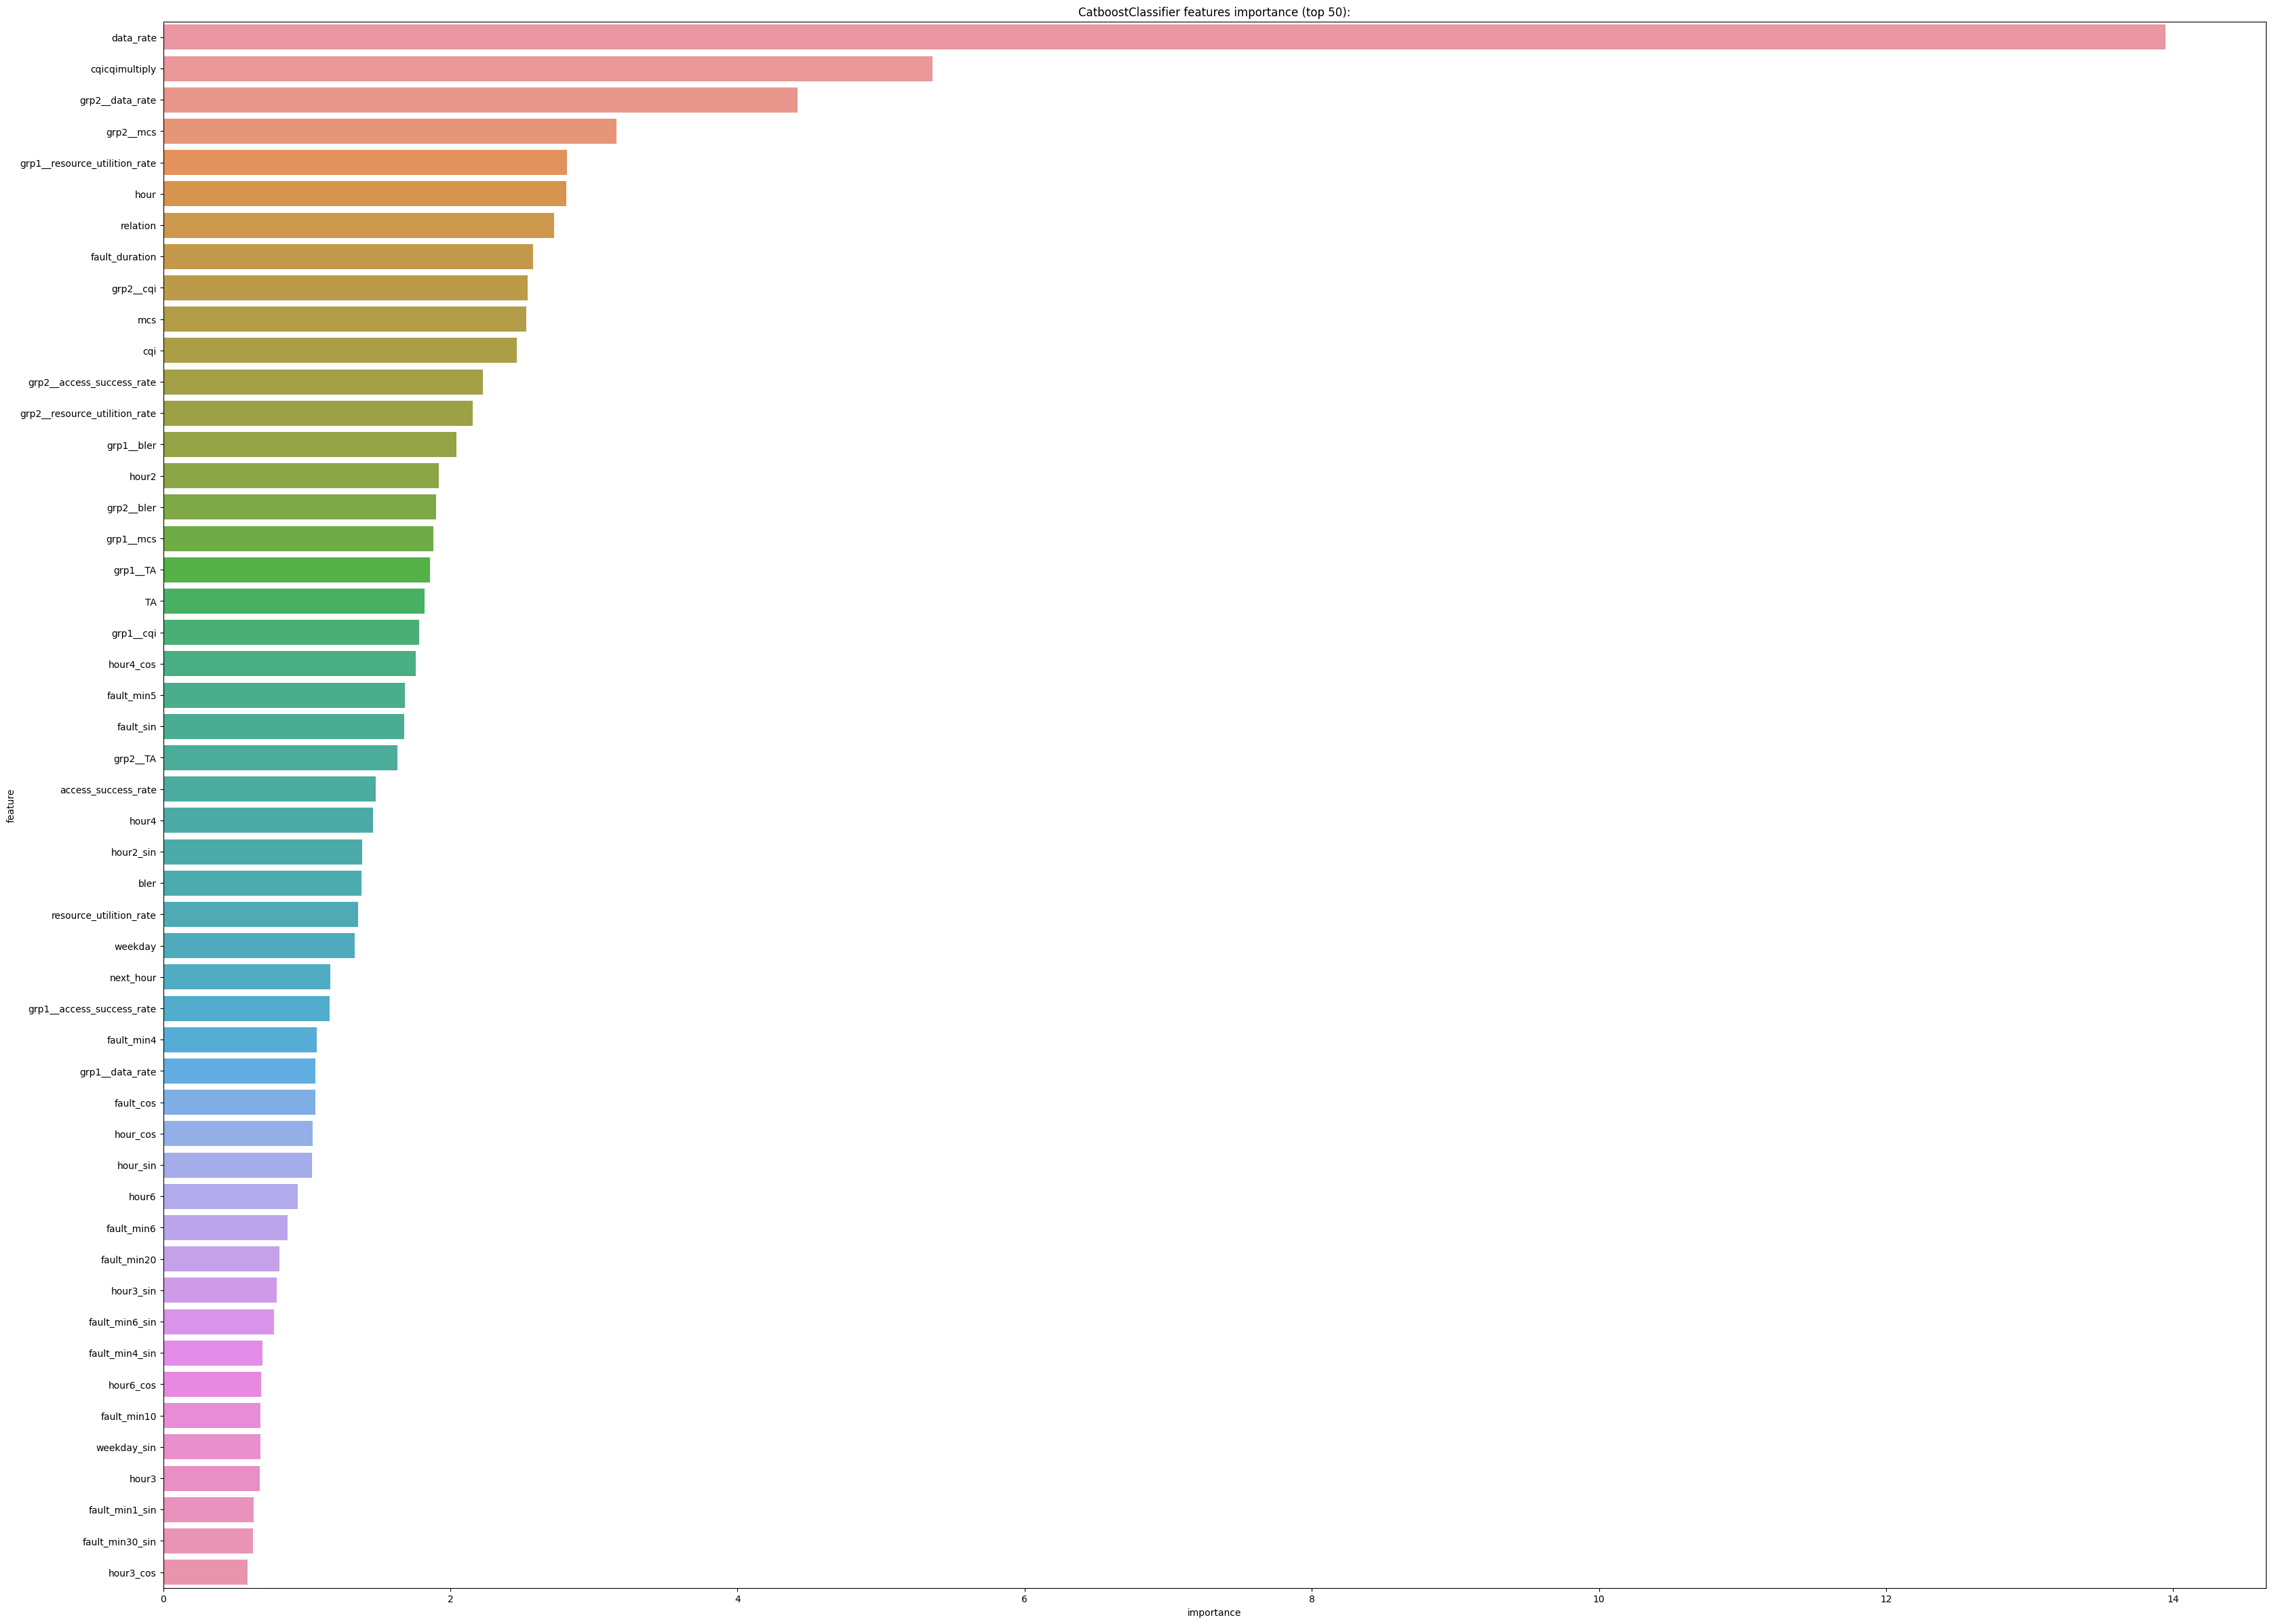

In [ ]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train.columns

plt.figure(figsize=(40, 30));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(50))
plt.title('CatboostClassifier features importance (top 50):');

<Axes: >

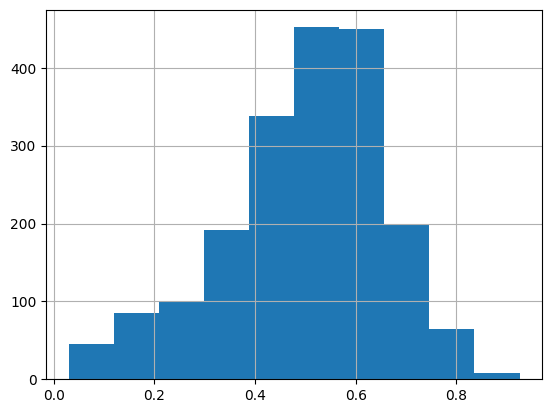

In [ ]:
pd.Series(test_predictions1).hist()

<Axes: ylabel='Density'>

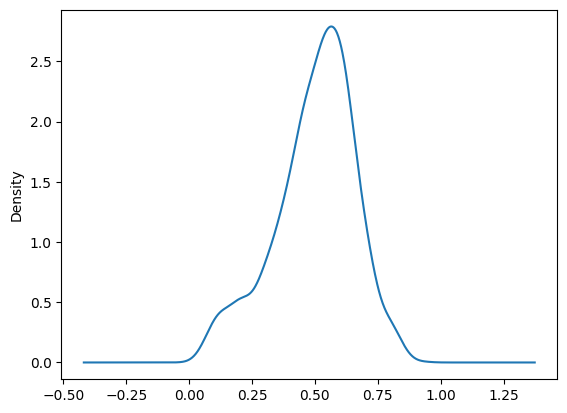

In [ ]:
pd.Series(test_predictions1).plot(kind='density')